# Probe Baselines 
Train probes across next-event prediction, context retrieval, session classification, and anomaly detection while capturing storage/compute costs per rung. Results go in `research/results/probe_metrics.csv`.


In [1]:
from __future__ import annotations
import json
import shutil
import subprocess
import sys
from pathlib import Path
import time
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

# Find repo root first
REPO_ROOT = Path.cwd()
while not (REPO_ROOT / 'cursor-telemetry').exists() and not (REPO_ROOT / 'research').exists():
    if REPO_ROOT == REPO_ROOT.parent:
        break
    REPO_ROOT = REPO_ROOT.parent

# Import shared rung extraction functions
RESEARCH_DIR = REPO_ROOT / 'research'
RUNG_EXTRACTORS_DIR = RESEARCH_DIR / 'rung_extractors'
if str(RUNG_EXTRACTORS_DIR) not in sys.path:
    sys.path.insert(0, str(RUNG_EXTRACTORS_DIR))
if str(RESEARCH_DIR) not in sys.path:
    sys.path.insert(0, str(RESEARCH_DIR))

from rung_extractors import (
    tokens_repr_str,
    semantic_edits_repr_str,
    functions_repr_str,
    motifs_repr_str,
    raw_repr_str,
)
TRACE_EXPORT = REPO_ROOT / 'research/data/companion_traces.jsonl'
TRACE_EXPORT.parent.mkdir(parents=True, exist_ok=True)
RESULTS_DIR = REPO_ROOT / 'research/results'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Export traces if needed (use Python script if available, otherwise skip if file exists)
def export_traces() -> None:
    EXPORT_SCRIPT_PY = REPO_ROOT / 'research/scripts/export_complete_traces.py'
    EXPORT_SCRIPT_SH = REPO_ROOT / 'cursor-telemetry/components/activity-logger/companion/scripts/export_cursor_data.sh'
    
    if EXPORT_SCRIPT_PY.exists():
        # Use Python export script
        subprocess.run([sys.executable, str(EXPORT_SCRIPT_PY)], check=True, cwd=str(REPO_ROOT))
    elif EXPORT_SCRIPT_SH.exists():
        # Fall back to bash script
        subprocess.run(['bash', str(EXPORT_SCRIPT_SH)], check=True)
    else:
        # If neither exists but file doesn't exist, raise error
        if not TRACE_EXPORT.exists():
            raise FileNotFoundError('No export script found and trace file does not exist')

if not TRACE_EXPORT.exists():
    print("Trace file not found. Exporting traces...")
    export_traces()
else:
    print(f"Trace file exists: {TRACE_EXPORT}")

with TRACE_EXPORT.open('r', encoding='utf-8') as fh:
    traces = [json.loads(line) for line in fh]
print(f'Loaded {len(traces)} traces')


Trace file exists: /Users/hamidaho/new_cursor/research/data/companion_traces.jsonl
Loaded 160 traces


In [2]:
# ============================================================================
# Rung Extraction Functions
# ============================================================================
# All rung extraction functions are imported from rung_extractors.py
# This ensures consistency across all notebooks and provides a single source of truth.
#
# Wrapper functions to match the expected interface (return strings)
def tokens_repr(trace):
    """Use shared tokens_repr_str from rung_extractors."""
    return tokens_repr_str(trace)

def edits_repr(trace):
    """Use shared semantic_edits_repr_str from rung_extractors."""
    return semantic_edits_repr_str(trace)

def functions_repr(trace):
    """Use shared functions_repr_str from rung_extractors."""
    return functions_repr_str(trace)

def motifs_repr(trace):
    """Use shared motifs_repr_str from rung_extractors."""
    return motifs_repr_str(trace)


def raw_repr(trace):
    """Use shared raw_repr_str from rung_extractors."""
    return raw_repr_str(trace)

RUNG_FUNCS = {
    'tokens': tokens_repr,
    'semantic_edits': edits_repr,
    'functions': functions_repr,
    'motifs': motifs_repr,
    'raw': raw_repr,
}

print("✓ Using shared rung extraction functions from rung_extractors.py")
print(f"  Available rungs: {list(RUNG_FUNCS.keys())}")
def label_from_trace(trace):
    events = trace.get('events', [])
    if not events:
        return 'none'
    return events[-1].get('type') or 'unknown'

# Improved label creation logic - creates balanced labels based on trace characteristics
def count_code_changes(trace):
    """Count code/file change events in trace."""
    code_change_types = [
        'code_change', 'file_change', 'file_create', 'file_delete', 
        'file_rename', 'entry_created'
    ]
    count = 0
    for event in trace.get('events', []):
        event_type = (event.get('type') or '').lower()
        if any(change_type in event_type for change_type in code_change_types):
            count += 1
        # Also check details for code content
        details = event.get('details', {})
        if isinstance(details, dict):
            if details.get('after_content') or details.get('before_content') or details.get('code'):
                count += 1
    return count

def count_unique_files(trace):
    """Count number of unique files modified in trace."""
    files = set()
    for event in trace.get('events', []):
        details = event.get('details', {})
        if isinstance(details, dict):
            file_path = details.get('file_path') or details.get('file')
            if file_path:
                files.add(str(file_path))
    return len(files)

def has_terminal_commands(trace):
    """Check if trace contains terminal commands."""
    for event in trace.get('events', []):
        event_type = (event.get('type') or '').lower()
        if 'terminal' in event_type or 'command' in event_type:
            return True
        details = event.get('details', {})
        if isinstance(details, dict) and details.get('command'):
            return True
    return False

def has_prompts(trace):
    """Check if trace contains prompts/AI interactions."""
    for event in trace.get('events', []):
        event_type = (event.get('type') or '').lower()
        if 'prompt' in event_type or 'conversation' in event_type:
            return True
        if event.get('ai_generated'):
            return True
    return False

def last_event_is_code_change(trace):
    """Check if last event is a code change (for next_event prediction)."""
    events = trace.get('events', [])
    if not events:
        return False
    last_event = events[-1]
    event_type = (last_event.get('type') or '').lower()
    code_types = ['code_change', 'file_change', 'entry_created']
    return any(code_type in event_type for code_type in code_types)

# Calculate cutoffs for balanced labels
event_counts = [len(trace.get('events', [])) for trace in traces]
code_change_counts = [count_code_changes(trace) for trace in traces]
file_counts = [count_unique_files(trace) for trace in traces]

anomaly_cutoff = np.percentile(event_counts, 90) if event_counts else 0
high_code_activity_cutoff = np.percentile(code_change_counts, 50) if code_change_counts else 0  # Median split
multi_file_cutoff = np.percentile(file_counts, 50) if file_counts else 1  # Median split

features = []
for trace in traces:
    entry = {}
    for name, fn in RUNG_FUNCS.items():
        entry[name] = fn(trace)
    
    entry['label'] = label_from_trace(trace)
    
    # Improved label creation - creates balanced binary labels
    # 1. next_code_change: Check if last event is a code change (for next-event prediction)
    entry['next_code_change'] = int(last_event_is_code_change(trace))
    
    # 2. high_code_activity: Traces with above-median code change count
    code_change_count = count_code_changes(trace)
    entry['high_code_activity'] = int(code_change_count > high_code_activity_cutoff)
    
    # 3. multi_file_session: Traces that modify multiple files (above median)
    unique_files = count_unique_files(trace)
    entry['multi_file_session'] = int(unique_files > multi_file_cutoff)
    
    # 4. has_terminal: Traces with terminal commands
    entry['has_terminal'] = int(has_terminal_commands(trace))
    
    # 5. has_prompts: Traces with AI prompts/interactions
    entry['has_prompts'] = int(has_prompts(trace))
    
    # 6. anomaly: Based on event count (top 10%)
    entry['anomaly'] = int(len(trace.get('events', [])) > anomaly_cutoff)
    
    # Target file for retrieval
    entry['target_file'] = next(
        (event.get('details', {}).get('file_path') or event.get('details', {}).get('file') 
         for event in reversed(trace.get('events', [])) if event.get('details')), 
        trace.get('workspace_path', 'unknown')
    )
    
    # Storage and term counts
    entry['storage_bytes'] = {name: len(entry[name].encode('utf-8')) for name in RUNG_FUNCS}
    entry['term_count'] = {name: len(entry[name].split()) for name in RUNG_FUNCS}
    
    features.append(entry)
print('Built {} feature rows'.format(len(features)))

# Debug: Check label distributions
print('\n' + '='*60)
print('Label Distribution Analysis')
print('='*60)

from collections import Counter

# Check all label distributions
label_names = [
    'next_code_change', 'high_code_activity', 'multi_file_session', 
    'has_terminal', 'has_prompts', 'anomaly'
]
for label_name in label_names:
    counts = [entry[label_name] for entry in features]
    positive = sum(counts)
    negative = len(counts) - positive
    print(f'\n{label_name}:')
    print(f'  Positive: {positive} ({positive/len(counts)*100:.1f}%)')
    print(f'  Negative: {negative} ({negative/len(counts)*100:.1f}%)')
    print(f'  Unique values: {set(counts)}')
    if positive == 0 or negative == 0:
        print(f'  ⚠ WARNING: Only one class present - will skip classification')
    elif positive < len(counts) * 0.1 or negative < len(counts) * 0.1:
        print(f'  ⚠ WARNING: Severe class imbalance (<10% minority class)')

# Check what labels are actually being generated
label_types = [entry['label'] for entry in features]
label_counter = Counter(label_types)
print(f'\nMost common event types (last event in trace):')
for label, count in label_counter.most_common(10):
    print(f'  {label}: {count}')

# Check event types in traces
all_event_types = []
for trace in traces:
    for event in trace.get('events', []):
        event_type = event.get('type', '').lower()
        if event_type:
            all_event_types.append(event_type)
event_type_counter = Counter(all_event_types)
print(f'\nMost common event types (all events):')
for etype, count in event_type_counter.most_common(10):
    print(f'  {etype}: {count}')


✓ Using shared rung extraction functions from rung_extractors.py
  Available rungs: ['tokens', 'semantic_edits', 'functions', 'motifs', 'raw']


Built 160 feature rows

Label Distribution Analysis

next_code_change:
  Positive: 160 (100.0%)
  Negative: 0 (0.0%)
  Unique values: {1}
  ⚠ WARNING: Only one class present - will skip classification

high_code_activity:
  Positive: 80 (50.0%)
  Negative: 80 (50.0%)
  Unique values: {0, 1}

multi_file_session:
  Positive: 78 (48.8%)
  Negative: 82 (51.2%)
  Unique values: {0, 1}

has_terminal:
  Positive: 0 (0.0%)
  Negative: 160 (100.0%)
  Unique values: {0}
  ⚠ WARNING: Only one class present - will skip classification

has_prompts:
  Positive: 0 (0.0%)
  Negative: 160 (100.0%)
  Unique values: {0}
  ⚠ WARNING: Only one class present - will skip classification

anomaly:
  Positive: 16 (10.0%)
  Negative: 144 (90.0%)
  Unique values: {0, 1}

Most common event types (last event in trace):
  code_change: 160

Most common event types (all events):
  code_change: 5537


In [3]:
def build_probe_dataset(rung: str, label: str):
    reps = [entry[rung] for entry in features]
    placeholder='empty_repr'
    cleaned=[repr if repr.strip() else placeholder for repr in reps]
    vec = TfidfVectorizer(max_features=4096)
    try:
        X = vec.fit_transform(cleaned).toarray()
    except ValueError:
        X = np.zeros((len(cleaned),1))
    y = np.array([entry[label] for entry in features], dtype=int)
    return X, y
results = []
# Updated task labels - balanced labels based on trace characteristics
task_labels = [
    ('next_code_change', 'next_event'),
    ('high_code_activity', 'code_activity_classification'),
    ('multi_file_session', 'multi_file_classification'),
    ('has_terminal', 'terminal_classification'),
    ('has_prompts', 'prompt_classification'),
    ('anomaly', 'anomaly_detection')
]

for rung in RUNG_FUNCS:
    for label_name, task in task_labels:
        X, y = build_probe_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            print(f'Skipping {rung} / {label_name} because only one class present')
            continue
        clf = LogisticRegression(max_iter=500)
        start = time.perf_counter()
        clf.fit(X, y)
        train_time = time.perf_counter() - start
        start = time.perf_counter()
        y_pred = clf.predict(X)
        infer_time = time.perf_counter() - start
        results.append({
            'rung': rung,
            'task': task,
            'accuracy': accuracy_score(y, y_pred),
            'f1': f1_score(y, y_pred),
            'train_time': train_time,
            'infer_time': infer_time,
            'storage_bytes': np.mean([entry['storage_bytes'][rung] for entry in features]),
            'avg_terms': np.mean([entry['term_count'][rung] for entry in features])
        })
df_probes = pd.DataFrame(results)
df_probes


Skipping tokens / next_code_change because only one class present
Skipping tokens / has_terminal because only one class present
Skipping tokens / has_prompts because only one class present
Skipping semantic_edits / next_code_change because only one class present
Skipping semantic_edits / has_terminal because only one class present
Skipping semantic_edits / has_prompts because only one class present
Skipping functions / next_code_change because only one class present
Skipping functions / has_terminal because only one class present
Skipping functions / has_prompts because only one class present
Skipping motifs / next_code_change because only one class present
Skipping motifs / has_terminal because only one class present
Skipping motifs / has_prompts because only one class present
Skipping raw / next_code_change because only one class present


Skipping raw / has_terminal because only one class present
Skipping raw / has_prompts because only one class present


,rung,task,accuracy,f1,train_time,infer_time,storage_bytes,avg_terms
0,tokens,code_activity_classification,0.70625,0.646617,0.008752,0.000223,1407.90625,201.70000
1,tokens,multi_file_classification,0.68750,0.615385,0.001252,0.000087,1407.90625,201.70000
2,tokens,anomaly_detection,0.90000,0.000000,0.001005,0.000057,1407.90625,201.70000
3,semantic_edits,code_activity_classification,0.83750,0.821918,0.001543,0.000091,1235.74375,38.31250
4,semantic_edits,multi_file_classification,0.85625,0.839161,0.001096,0.000078,1235.74375,38.31250
5,semantic_edits,anomaly_detection,0.90000,0.000000,0.001207,0.000087,1235.74375,38.31250
6,functions,code_activity_classification,0.80000,0.794872,0.000867,0.000056,355.90625,35.20000
7,functions,multi_file_classification,0.81875,0.812903,0.000905,0.000059,355.90625,35.20000
8,functions,anomaly_detection,0.90000,0.000000,0.000754,0.000052,355.90625,35.20000
9,motifs,code_activity_classification,1.00000,1.000000,0.000900,0.000054,56.70625,6.76250


In [4]:
def retrieval_metrics(rung: str, ks=(1, 5, 10)):
    reps = [entry[rung] for entry in features]
    targets = [entry['target_file'] for entry in features]
    placeholder = 'empty_representation'
    clean_reps = [rep if rep.strip() else placeholder for rep in reps]
    vec = TfidfVectorizer(max_features=4096)
    matrix = vec.fit_transform(clean_reps)
    sims = cosine_similarity(matrix)
    np.fill_diagonal(sims, -np.inf)
    results = {k: 0 for k in ks}
    for idx, target in enumerate(targets):
        ranks = np.argsort(-sims[idx])
        for k in ks:
            if any(targets[pos] == target for pos in ranks[:k]):
                results[k] += 1
    total = len(targets)
    return {f'recall@{k}': results[k] / total for k in ks}
retrieval_stats = []
for rung in RUNG_FUNCS:
    start = time.perf_counter()
    recs = retrieval_metrics(rung)
    elapsed = time.perf_counter() - start
    recs.update({
        'rung': rung,
        'task': 'context_retrieval',
        'latency': elapsed,
        'storage_bytes': np.mean([entry['storage_bytes'][rung] for entry in features]),
        'avg_terms': np.mean([entry['term_count'][rung] for entry in features])
    })
    retrieval_stats.append(recs)
df_retrieval = pd.DataFrame(retrieval_stats)
df_final = pd.concat([df_probes, df_retrieval], ignore_index=True, sort=False)
df_final.to_csv(REPO_ROOT / 'research/results/probe_metrics.csv', index=False)
df_final


,rung,task,accuracy,f1,train_time,infer_time,storage_bytes,avg_terms,recall@1,recall@5,recall@10,latency
0,tokens,code_activity_classification,0.70625,0.646617,0.008752,0.000223,1407.90625,201.70000,NaN,NaN,NaN,NaN
1,tokens,multi_file_classification,0.68750,0.615385,0.001252,0.000087,1407.90625,201.70000,NaN,NaN,NaN,NaN
2,tokens,anomaly_detection,0.90000,0.000000,0.001005,0.000057,1407.90625,201.70000,NaN,NaN,NaN,NaN
3,semantic_edits,code_activity_classification,0.83750,0.821918,0.001543,0.000091,1235.74375,38.31250,NaN,NaN,NaN,NaN
4,semantic_edits,multi_file_classification,0.85625,0.839161,0.001096,0.000078,1235.74375,38.31250,NaN,NaN,NaN,NaN
5,semantic_edits,anomaly_detection,0.90000,0.000000,0.001207,0.000087,1235.74375,38.31250,NaN,NaN,NaN,NaN
6,functions,code_activity_classification,0.80000,0.794872,0.000867,0.000056,355.90625,35.20000,NaN,NaN,NaN,NaN
7,functions,multi_file_classification,0.81875,0.812903,0.000905,0.000059,355.90625,35.20000,NaN,NaN,NaN,NaN
8,functions,anomaly_detection,0.90000,0.000000,0.000754,0.000052,355.90625,35.20000,NaN,NaN,NaN,NaN
9,motifs,code_activity_classification,1.00000,1.000000,0.000900,0.000054,56.70625,6.76250,NaN,NaN,NaN,NaN


In [5]:
# ============================================================================
# Dataset Parsing and Interpretation
# ============================================================================
# Analyze the dataset to understand why certain rungs perform better/worse

print("="*80)
print("DATASET PARSING AND INTERPRETATION")
print("="*80)

# 1. Representation Characteristics Analysis
print("\n1. REPRESENTATION CHARACTERISTICS")
print("-" * 80)

from collections import Counter
import re

rung_stats = {}
for rung in RUNG_FUNCS.keys():
    reps = [entry[rung] for entry in features]
    
    # Vocabulary analysis
    all_terms = []
    for rep in reps:
        if rep and rep.strip():
            terms = rep.split()
            all_terms.extend(terms)
    
    vocab = Counter(all_terms)
    unique_terms = len(vocab)
    total_terms = len(all_terms)
    avg_length = np.mean([len(rep.split()) for rep in reps if rep.strip()])
    
    # Diversity metrics
    if total_terms > 0:
        diversity = unique_terms / total_terms  # Type-token ratio
        most_common = vocab.most_common(10)
    else:
        diversity = 0
        most_common = []
    
    rung_stats[rung] = {
        'vocab_size': unique_terms,
        'total_terms': total_terms,
        'avg_length': avg_length,
        'diversity': diversity,
        'most_common': most_common,
        'empty_reprs': sum(1 for rep in reps if not rep or not rep.strip()),
    }
    
    print(f"\n{rung.upper()}:")
    print(f"  Vocabulary size: {unique_terms}")
    print(f"  Total terms: {total_terms}")
    print(f"  Avg representation length: {avg_length:.1f} terms")
    print(f"  Diversity (type-token ratio): {diversity:.3f}")
    print(f"  Empty representations: {rung_stats[rung]['empty_reprs']} ({rung_stats[rung]['empty_reprs']/len(reps)*100:.1f}%)")
    if most_common:
        print(f"  Top 10 most common terms:")
        for term, count in most_common:
            print(f"    '{term}': {count} ({count/total_terms*100:.1f}%)")

# 2. Feature Importance Analysis (for successful classifications)
print("\n\n2. FEATURE IMPORTANCE ANALYSIS")
print("-" * 80)

# Analyze which features are most important for each successful task
for rung in RUNG_FUNCS.keys():
    for label_name, task in task_labels:
        if label_name not in ['high_code_activity', 'multi_file_session']:  # Focus on balanced tasks
            continue
        
        X, y = build_probe_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            continue
        
        clf = LogisticRegression(max_iter=500)
        clf.fit(X, y)
        
        # Get feature importance (coefficient magnitude)
        feature_importance = np.abs(clf.coef_[0])
        top_indices = np.argsort(feature_importance)[-10:][::-1]
        
        # Get feature names from vectorizer
        reps = [entry[rung] for entry in features]
        cleaned = [repr if repr.strip() else 'empty_repr' for repr in reps]
        vec = TfidfVectorizer(max_features=4096)
        try:
            vec.fit_transform(cleaned)
            feature_names = vec.get_feature_names_out()
        except:
            continue
        
        print(f"\n{rung} / {task}:")
        print(f"  Accuracy: {accuracy_score(y, clf.predict(X)):.4f}")
        print(f"  F1: {f1_score(y, clf.predict(X)):.4f}")
        print(f"  Top 10 most important features:")
        for idx in top_indices[:10]:
            if idx < len(feature_names):
                importance = feature_importance[idx]
                feature_name = feature_names[idx]
                print(f"    '{feature_name}': {importance:.4f}")

# 3. Representation Overlap Analysis
print("\n\n3. REPRESENTATION OVERLAP ANALYSIS")
print("-" * 80)
print("How much do representations overlap across rungs?")

# Sample a few traces and show their representations
print("\nSample trace representations (first 3 traces):")
for i in range(min(3, len(features))):
    print(f"\nTrace {i+1}:")
    for rung in RUNG_FUNCS.keys():
        rep = features[i][rung]
        preview = rep[:200] + "..." if len(rep) > 200 else rep
        print(f"  {rung:15}: {preview}")

# 4. Performance vs Representation Characteristics
print("\n\n4. PERFORMANCE VS REPRESENTATION CHARACTERISTICS")
print("-" * 80)

# Create summary dataframe
summary_data = []
for rung in RUNG_FUNCS.keys():
    stats = rung_stats[rung]
    
    # Get performance metrics
    perf_data = df_final[df_final['rung'] == rung]
    if not perf_data.empty:
        avg_acc = perf_data['accuracy'].mean() if 'accuracy' in perf_data.columns else np.nan
        avg_f1 = perf_data['f1'].mean() if 'f1' in perf_data.columns else np.nan
        avg_recall1 = perf_data['recall@1'].mean() if 'recall@1' in perf_data.columns else np.nan
    else:
        avg_acc = avg_f1 = avg_recall1 = np.nan
    
    summary_data.append({
        'rung': rung,
        'vocab_size': stats['vocab_size'],
        'avg_length': stats['avg_length'],
        'diversity': stats['diversity'],
        'storage_bytes': stats.get('storage_bytes', np.nan),
        'avg_accuracy': avg_acc,
        'avg_f1': avg_f1,
        'avg_recall@1': avg_recall1,
    })

df_summary = pd.DataFrame(summary_data)
print("\nSummary Statistics:")
print(df_summary.to_string(index=False))

# 5. Error Analysis
print("\n\n5. ERROR ANALYSIS")
print("-" * 80)

for rung in RUNG_FUNCS.keys():
    for label_name, task in task_labels:
        if label_name not in ['high_code_activity', 'multi_file_session']:
            continue
        
        X, y = build_probe_dataset(rung, label_name)
        if len(np.unique(y)) < 2:
            continue
        
        clf = LogisticRegression(max_iter=500)
        clf.fit(X, y)
        y_pred = clf.predict(X)
        
        # Find misclassified examples
        errors = np.where(y != y_pred)[0]
        if len(errors) > 0:
            print(f"\n{rung} / {task}: {len(errors)} errors ({len(errors)/len(y)*100:.1f}%)")
            # Show a few error examples
            for err_idx in errors[:3]:
                print(f"  Error example {err_idx}:")
                print(f"    True label: {y[err_idx]}, Predicted: {y_pred[err_idx]}")
                rep = features[err_idx][rung]
                preview = rep[:150] + "..." if len(rep) > 150 else rep
                print(f"    Representation: {preview}")

print("\n" + "="*80)
print("✓ Dataset parsing complete")
print("="*80)


DATASET PARSING AND INTERPRETATION

1. REPRESENTATION CHARACTERISTICS
--------------------------------------------------------------------------------

TOKENS:
  Vocabulary size: 326
  Total terms: 32272
  Avg representation length: 201.7 terms
  Diversity (type-token ratio): 0.010
  Empty representations: 0 (0.0%)
  Top 10 most common terms:
    'OPERATOR': 4283 (13.3%)
    'PAREN': 852 (2.6%)
    'ASSIGN': 748 (2.3%)
    '-': 727 (2.3%)
    'STRING_LITERAL': 704 (2.2%)
    'BRACE': 655 (2.0%)
    'NUMBER': 587 (1.8%)
    '/': 481 (1.5%)
    '>': 288 (0.9%)
    'BRACKET': 286 (0.9%)

SEMANTIC_EDITS:
  Vocabulary size: 1010
  Total terms: 6130
  Avg representation length: 38.3 terms
  Diversity (type-token ratio): 0.165
  Empty representations: 0 (0.0%)
  Top 10 most common terms:
    '→': 2759 (45.0%)
    'code_change->components/activity-logger/companion/data/companion.db-journal': 567 (9.2%)
    'code_change->components/activity-logger/public/new-dashboard.js': 294 (4.8%)
    'code_


raw / code_activity_classification:
  Accuracy: 0.9125
  F1: 0.9136
  Top 10 most important features:
    'git': 1.6181
    'objects': 1.2706
    'import': 1.0908
    'str': 1.0780
    'require': 1.0692
    'const': 0.8275
    'path': 0.8135
    'new_cursor': 0.7677
    'summary': 0.7275
    'after': 0.7268

raw / multi_file_classification:
  Accuracy: 0.8812
  F1: 0.8725
  Top 10 most important features:
    'str': 1.9851
    'git': 1.6500
    'objects': 1.1744
    'companion': 1.0972
    'name': 0.9704
    'import': 0.8477
    'file': 0.7807
    'require': 0.7465
    'after': 0.7013
    'summary': 0.7008


3. REPRESENTATION OVERLAP ANALYSIS
--------------------------------------------------------------------------------
How much do representations overlap across rungs?

Sample trace representations (first 3 traces):

Trace 1:
  tokens         : ID_001 ID_002 ID_003 ID_004 OPERATOR PAREN OPERATOR STRING_LITERAL CONST ID_005 ASSIGN BRACE ID_006 ID_007 FROM ID_008 ID_009 OPERATOR OPERA


raw / code_activity_classification: 14 errors (8.8%)
  Error example 3:
    True label: 0, Predicted: 1
    Representation: CODE_CHANGES:

  Change 1:
    File: components/activity-logger/public/new-dashboard.js
    After: /**
 * [NAME] - [NAME]
 * Clean, modern implementat...
  Error example 20:
    True label: 1, Predicted: 0
    Representation: CODE_CHANGES:

  Change 1:
    File: components/activity-logger/companion/src/reasoning-engine.js
    After: /**
 * [NAME] with [NAME]
 * Provides int...
  Error example 21:
    True label: 1, Predicted: 0
    Representation: CODE_CHANGES:

  Change 1:
    File: AI-ASSISTANT-SETUP.md
    After: # AI [NAME] dashboard includes an intelligent chat assistant that can answer que...

raw / multi_file_classification: 19 errors (11.9%)
  Error example 5:
    True label: 1, Predicted: 0
    Representation: CODE_CHANGES:

  Change 1:
    File: Desktop/Screenshot 2025-10-23 at 2.22.41 AM.png
    After: �PNG

IHDR  `[STR]`�^�@!�"[STR]"�H,���!��Q �.

In [6]:
# ============================================================================
# Visualization: Performance Analysis (Altair)
# ============================================================================

import altair as alt
import pandas as pd

# Enable high-resolution export
alt.renderers.enable('default')
alt.data_transformers.enable('default')

# Filter out NaN values for classification tasks
class_df = df_final[df_final['task'].isin(['code_activity_classification', 'multi_file_classification', 'anomaly_detection'])].copy()
class_df = class_df.dropna(subset=['accuracy', 'f1'])

# 1. Performance Comparison Across Tasks
if not class_df.empty:
    # Prepare data for accuracy plot
    pivot_acc = class_df.pivot_table(values='accuracy', index='rung', columns='task', aggfunc='mean').reset_index()
    pivot_acc_melted = pivot_acc.melt(id_vars='rung', var_name='task', value_name='accuracy')
    pivot_acc_melted['task'] = pivot_acc_melted['task'].str.replace('_', ' ').str.title()
    
    # Plot 1: Accuracy by Rung and Task
    chart_acc = alt.Chart(pivot_acc_melted).mark_bar(opacity=0.8, cornerRadius=4).encode(
        x=alt.X('rung:N', title='Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('accuracy:Q', title='Accuracy', scale=alt.Scale(domain=[0, 1.1])),
        color=alt.Color('task:N', 
                       scale=alt.Scale(domain=['Code Activity Classification', 'Multi File Classification', 'Anomaly Detection'],
                                      range=['#1f77b4', '#ff7f0e', '#2ca02c']),
                       legend=alt.Legend(title='Task', orient='right')),
        tooltip=['rung', 'task', alt.Tooltip('accuracy:Q', format='.3f')]
    ).properties(
        width=300,
        height=250,
        title='Classification Accuracy by Rung'
    )
    
    # Plot 2: F1 Score by Rung and Task
    pivot_f1 = class_df.pivot_table(values='f1', index='rung', columns='task', aggfunc='mean').reset_index()
    pivot_f1_melted = pivot_f1.melt(id_vars='rung', var_name='task', value_name='f1')
    pivot_f1_melted['task'] = pivot_f1_melted['task'].str.replace('_', ' ').str.title()
    
    chart_f1 = alt.Chart(pivot_f1_melted).mark_bar(opacity=0.8, cornerRadius=4).encode(
        x=alt.X('rung:N', title='Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('f1:Q', title='F1 Score', scale=alt.Scale(domain=[0, 1.1])),
        color=alt.Color('task:N',
                       scale=alt.Scale(domain=['Code Activity Classification', 'Multi File Classification', 'Anomaly Detection'],
                                      range=['#1f77b4', '#ff7f0e', '#2ca02c']),
                       legend=alt.Legend(title='Task', orient='right')),
        tooltip=['rung', 'task', alt.Tooltip('f1:Q', format='.3f')]
    ).properties(
        width=300,
        height=250,
        title='F1 Score by Rung'
    )

# Plot 3: Context Retrieval Performance
retrieval_df = df_final[df_final['task'] == 'context_retrieval'].dropna(subset=['recall@1', 'recall@5', 'recall@10']).copy()
if not retrieval_df.empty:
    retrieval_melted = retrieval_df.melt(
        id_vars='rung',
        value_vars=['recall@1', 'recall@5', 'recall@10'],
        var_name='metric',
        value_name='recall'
    )
    retrieval_melted['metric'] = retrieval_melted['metric'].str.replace('recall@', 'Recall@')
    
    # For grouped bars, we need to combine rung and metric
    chart_retrieval = alt.Chart(retrieval_melted).mark_bar(opacity=0.8, cornerRadius=4).encode(
        x=alt.X('rung:N', title='Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('recall:Q', title='Recall', scale=alt.Scale(domain=[0, 1])),
        color=alt.Color('metric:N',
                       scale=alt.Scale(domain=['Recall@1', 'Recall@5', 'Recall@10'],
                                      range=['#1f77b4', '#ff7f0e', '#2ca02c']),
                       legend=alt.Legend(title='Metric', orient='right')),
        tooltip=['rung', 'metric', alt.Tooltip('recall:Q', format='.3f')]
    ).properties(
        width=300,
        height=250,
        title='Context Retrieval Performance'
    )

# Plot 4: Storage Efficiency vs Performance Trade-off
if not class_df.empty:
    task_df = class_df[class_df['task'] == 'code_activity_classification'].dropna(subset=['accuracy', 'storage_bytes']).copy()
    if not task_df.empty:
        chart_tradeoff = alt.Chart(task_df).mark_circle(size=200, opacity=0.7).encode(
            x=alt.X('storage_bytes:Q', title='Storage (bytes)', scale=alt.Scale(type='log')),
            y=alt.Y('accuracy:Q', title='Accuracy'),
            color=alt.Color('rung:N', 
                           scale=alt.Scale(scheme='viridis'),
                           legend=alt.Legend(title='Rung', orient='right')),
            tooltip=['rung', alt.Tooltip('accuracy:Q', format='.3f'), alt.Tooltip('storage_bytes:Q', format=',.0f')]
        ).properties(
            width=300,
            height=250,
            title='Storage vs Accuracy Trade-off'
        )

# Save each chart individually as PNG
chart_config = {
    'background': 'white',
    'padding': {'left': 10, 'top': 10, 'right': 10, 'bottom': 10}
}

if not class_df.empty:
    # Chart 1: Classification Accuracy
    chart_acc_configured = chart_acc.configure(**chart_config).configure_title(
        fontSize=16,
        fontWeight='bold',
        anchor='start'
    ).configure_axis(
        labelFontSize=11,
        titleFontSize=12,
        titleFontWeight='bold'
    ).configure_legend(
        labelFontSize=10,
        titleFontSize=11,
        titleFontWeight='bold'
    )
    chart_acc_configured.save(REPO_ROOT / 'research/results/classification_accuracy_by_rung.png', scale_factor=2)
    print("✓ Saved classification_accuracy_by_rung.png")
    
    # Chart 2: F1 Score
    chart_f1_configured = chart_f1.configure(**chart_config).configure_title(
        fontSize=16,
        fontWeight='bold',
        anchor='start'
    ).configure_axis(
        labelFontSize=11,
        titleFontSize=12,
        titleFontWeight='bold'
    ).configure_legend(
        labelFontSize=10,
        titleFontSize=11,
        titleFontWeight='bold'
    )
    chart_f1_configured.save(REPO_ROOT / 'research/results/f1_score_by_rung.png', scale_factor=2)
    print("✓ Saved f1_score_by_rung.png")

# Save retrieval chart
if not retrieval_df.empty:
    chart_retrieval_configured = chart_retrieval.configure(**chart_config).configure_title(
        fontSize=16,
        fontWeight='bold',
        anchor='start'
    ).configure_axis(
        labelFontSize=11,
        titleFontSize=12,
        titleFontWeight='bold'
    ).configure_legend(
        labelFontSize=10,
        titleFontSize=11,
        titleFontWeight='bold'
    )
    chart_retrieval_configured.save(REPO_ROOT / 'research/results/context_retrieval_performance.png', scale_factor=2)
    print("✓ Saved context_retrieval_performance.png")

# Save storage vs accuracy trade-off chart
if not class_df.empty:
    task_df = class_df[class_df['task'] == 'code_activity_classification'].dropna(subset=['accuracy', 'storage_bytes']).copy()
    if not task_df.empty:
        chart_tradeoff_configured = chart_tradeoff.configure(**chart_config).configure_title(
            fontSize=16,
            fontWeight='bold',
            anchor='start'
        ).configure_axis(
            labelFontSize=11,
            titleFontSize=12,
            titleFontWeight='bold'
        ).configure_legend(
            labelFontSize=10,
            titleFontSize=11,
            titleFontWeight='bold'
        )
        chart_tradeoff_configured.save(REPO_ROOT / 'research/results/storage_vs_accuracy_tradeoff.png', scale_factor=2)
        print("✓ Saved storage_vs_accuracy_tradeoff.png")

# Also create combined HTML for interactive viewing
if not class_df.empty and not retrieval_df.empty:
    top_row = alt.hconcat(chart_acc, chart_f1, spacing=20)
    bottom_row = alt.hconcat(chart_retrieval, chart_tradeoff, spacing=20)
    combined = alt.vconcat(top_row, bottom_row, spacing=30).configure(**chart_config).configure_title(
        fontSize=16,
        fontWeight='bold',
        anchor='start'
    ).configure_axis(
        labelFontSize=11,
        titleFontSize=12,
        titleFontWeight='bold'
    ).configure_legend(
        labelFontSize=10,
        titleFontSize=11,
        titleFontWeight='bold'
    )
    
    # Save interactive HTML (combined view)
    combined.save(REPO_ROOT / 'research/results/probe_performance_analysis.html')
    print("✓ Saved interactive HTML to research/results/probe_performance_analysis.html")
    
    combined.display()

# 2. Representation Characteristics Visualization (Altair)
if 'df_summary' in locals() and not df_summary.empty:
    # Plot 1: Vocabulary Size
    chart_vocab = alt.Chart(df_summary).mark_bar(color='#1f77b4', opacity=0.7, cornerRadius=4).encode(
        x=alt.X('rung:N', title='Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('vocab_size:Q', title='Unique Terms'),
        tooltip=['rung', alt.Tooltip('vocab_size:Q', format=',.0f')]
    ).properties(
        width=300,
        height=250,
        title='Vocabulary Size by Rung'
    )
    
    # Plot 2: Average Representation Length
    chart_avg_length = alt.Chart(df_summary).mark_bar(color='#ff7f0e', opacity=0.7, cornerRadius=4).encode(
        x=alt.X('rung:N', title='Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('avg_length:Q', title='Avg Terms per Representation'),
        tooltip=['rung', alt.Tooltip('avg_length:Q', format='.1f')]
    ).properties(
        width=300,
        height=250,
        title='Average Representation Length'
    )
    
    # Plot 3: Diversity (Type-Token Ratio)
    chart_diversity = alt.Chart(df_summary).mark_bar(color='#2ca02c', opacity=0.7, cornerRadius=4).encode(
        x=alt.X('rung:N', title='Rung', sort=None, axis=alt.Axis(labelAngle=-45)),
        y=alt.Y('diversity:Q', title='Type-Token Ratio'),
        tooltip=['rung', alt.Tooltip('diversity:Q', format='.3f')]
    ).properties(
        width=300,
        height=250,
        title='Representation Diversity'
    )
    
    # Plot 4: Performance vs Diversity
    task_df = class_df[class_df['task'] == 'code_activity_classification'].dropna(subset=['accuracy']).copy()
    if not task_df.empty and 'diversity' in df_summary.columns:
        merged = task_df.merge(df_summary[['rung', 'diversity']], on='rung', how='left')
        merged = merged.dropna(subset=['accuracy', 'diversity'])
        if not merged.empty:
            chart_diversity_acc = alt.Chart(merged).mark_circle(size=200, opacity=0.7).encode(
                x=alt.X('diversity:Q', title='Diversity (Type-Token Ratio)'),
                y=alt.Y('accuracy:Q', title='Accuracy'),
                color=alt.Color('rung:N', 
                               scale=alt.Scale(scheme='viridis'),
                               legend=alt.Legend(title='Rung', orient='right')),
                tooltip=['rung', alt.Tooltip('diversity:Q', format='.3f'), alt.Tooltip('accuracy:Q', format='.3f')]
            ).properties(
                width=300,
                height=250,
                title='Diversity vs Accuracy'
            )
            
            # Save each chart individually as PNG
            chart_config_char = {
                'background': 'white',
                'padding': {'left': 10, 'top': 10, 'right': 10, 'bottom': 10}
            }
            
            # Chart 1: Vocabulary Size
            chart_vocab_configured = chart_vocab.configure(**chart_config_char).configure_title(
                fontSize=16,
                fontWeight='bold',
                anchor='start'
            ).configure_axis(
                labelFontSize=11,
                titleFontSize=12,
                titleFontWeight='bold'
            )
            chart_vocab_configured.save(REPO_ROOT / 'research/results/vocabulary_size_by_rung.png', scale_factor=2)
            print("✓ Saved vocabulary_size_by_rung.png")
            
            # Chart 2: Average Representation Length
            chart_avg_length_configured = chart_avg_length.configure(**chart_config_char).configure_title(
                fontSize=16,
                fontWeight='bold',
                anchor='start'
            ).configure_axis(
                labelFontSize=11,
                titleFontSize=12,
                titleFontWeight='bold'
            )
            chart_avg_length_configured.save(REPO_ROOT / 'research/results/avg_representation_length.png', scale_factor=2)
            print("✓ Saved avg_representation_length.png")
            
            # Chart 3: Diversity
            chart_diversity_configured = chart_diversity.configure(**chart_config_char).configure_title(
                fontSize=16,
                fontWeight='bold',
                anchor='start'
            ).configure_axis(
                labelFontSize=11,
                titleFontSize=12,
                titleFontWeight='bold'
            )
            chart_diversity_configured.save(REPO_ROOT / 'research/results/representation_diversity.png', scale_factor=2)
            print("✓ Saved representation_diversity.png")
            
            # Chart 4: Diversity vs Accuracy
            chart_diversity_acc_configured = chart_diversity_acc.configure(**chart_config_char).configure_title(
                fontSize=16,
                fontWeight='bold',
                anchor='start'
            ).configure_axis(
                labelFontSize=11,
                titleFontSize=12,
                titleFontWeight='bold'
            ).configure_legend(
                labelFontSize=10,
                titleFontSize=11,
                titleFontWeight='bold'
            )
            chart_diversity_acc_configured.save(REPO_ROOT / 'research/results/diversity_vs_accuracy.png', scale_factor=2)
            print("✓ Saved diversity_vs_accuracy.png")
            
            # Also create combined HTML for interactive viewing
            top_row_char = alt.hconcat(chart_vocab, chart_avg_length, spacing=20)
            bottom_row_char = alt.hconcat(chart_diversity, chart_diversity_acc, spacing=20)
            combined_char = alt.vconcat(top_row_char, bottom_row_char, spacing=30).configure(**chart_config_char).configure_title(
                fontSize=16,
                fontWeight='bold',
                anchor='start'
            ).configure_axis(
                labelFontSize=11,
                titleFontSize=12,
                titleFontWeight='bold'
            )
            
            # Save interactive HTML (combined view)
            combined_char.save(REPO_ROOT / 'research/results/representation_characteristics.html')
            print("✓ Saved interactive HTML to research/results/representation_characteristics.html")
            

            combined_char.display()
# Copy images to landing page
LANDING_IMAGES_DIR = REPO_ROOT / 'telemetry-landing/public/images'
LANDING_IMAGES_DIR.mkdir(parents=True, exist_ok=True)
images_to_copy = [
    'classification_accuracy_by_rung.png',
    'f1_score_by_rung.png',
    'context_retrieval_performance.png',
    'storage_vs_accuracy_tradeoff.png',
    'vocabulary_size_by_rung.png',
    'representation_diversity.png',
]
for img_name in images_to_copy:
    src = REPO_ROOT / 'research/results' / img_name
    dst = LANDING_IMAGES_DIR / img_name
    if src.exists():
        shutil.copy2(src, dst)
        print(f'✓ Copied {img_name} to landing page')
    else:
        print(f'⚠ {img_name} not found - run cell to generate')


✓ Saved classification_accuracy_by_rung.png
✓ Saved f1_score_by_rung.png
✓ Saved context_retrieval_performance.png


✓ Saved storage_vs_accuracy_tradeoff.png
✓ Saved interactive HTML to research/results/probe_performance_analysis.html


alt.VConcatChart(...)

✓ Saved vocabulary_size_by_rung.png
✓ Saved avg_representation_length.png


✓ Saved representation_diversity.png
✓ Saved diversity_vs_accuracy.png
✓ Saved interactive HTML to research/results/representation_characteristics.html


alt.VConcatChart(...)

✓ Copied classification_accuracy_by_rung.png to landing page
✓ Copied f1_score_by_rung.png to landing page


✓ Copied context_retrieval_performance.png to landing page
✓ Copied storage_vs_accuracy_tradeoff.png to landing page
✓ Copied vocabulary_size_by_rung.png to landing page
✓ Copied representation_diversity.png to landing page


In [7]:
# ============================================================================
# Detailed Results Interpretation
# ============================================================================

print("="*80)
print("DETAILED RESULTS INTERPRETATION")
print("="*80)

# Create comprehensive interpretation
interpretation = []

for rung in RUNG_FUNCS.keys():
    rung_data = df_final[df_final['rung'] == rung]
    
    # Classification performance
    class_data = rung_data[rung_data['task'].isin(['code_activity_classification', 'multi_file_classification'])]
    if not class_data.empty:
        avg_acc = class_data['accuracy'].mean()
        avg_f1 = class_data['f1'].mean()
    else:
        avg_acc = avg_f1 = np.nan
    
    # Retrieval performance
    retrieval_data = rung_data[rung_data['task'] == 'context_retrieval']
    if not retrieval_data.empty:
        recall1 = retrieval_data['recall@1'].iloc[0] if 'recall@1' in retrieval_data.columns else np.nan
        recall5 = retrieval_data['recall@5'].iloc[0] if 'recall@5' in retrieval_data.columns else np.nan
        recall10 = retrieval_data['recall@10'].iloc[0] if 'recall@10' in retrieval_data.columns else np.nan
    else:
        recall1 = recall5 = recall10 = np.nan
    
    # Storage
    storage = rung_data['storage_bytes'].iloc[0] if 'storage_bytes' in rung_data.columns else np.nan
    terms = rung_data['avg_terms'].iloc[0] if 'avg_terms' in rung_data.columns else np.nan
    
    # Stats
    stats = rung_stats.get(rung, {})
    
    interpretation.append({
        'rung': rung,
        'classification_accuracy': avg_acc,
        'classification_f1': avg_f1,
        'retrieval_recall@1': recall1,
        'retrieval_recall@5': recall5,
        'retrieval_recall@10': recall10,
        'storage_bytes': storage,
        'avg_terms': terms,
        'vocab_size': stats.get('vocab_size', np.nan),
        'diversity': stats.get('diversity', np.nan),
    })

df_interpretation = pd.DataFrame(interpretation)

print("\nComprehensive Performance Summary:")
print(df_interpretation.to_string(index=False))

# Key findings
print("\n\nKEY FINDINGS:")
print("-" * 80)

# Find best performers
best_class = df_interpretation.loc[df_interpretation['classification_f1'].idxmax()]
best_retrieval = df_interpretation.loc[df_interpretation['retrieval_recall@5'].idxmax()]
most_efficient = df_interpretation.loc[df_interpretation['storage_bytes'].idxmin()]

print(f"\n1. Best Classification Performance:")
print(f"   Rung: {best_class['rung']}")
print(f"   Accuracy: {best_class['classification_accuracy']:.4f}")
print(f"   F1: {best_class['classification_f1']:.4f}")
print(f"   Storage: {best_class['storage_bytes']:.1f} bytes")

print(f"\n2. Best Retrieval Performance:")
print(f"   Rung: {best_retrieval['rung']}")
print(f"   Recall@1: {best_retrieval['retrieval_recall@1']:.4f}")
print(f"   Recall@5: {best_retrieval['retrieval_recall@5']:.4f}")
print(f"   Recall@10: {best_retrieval['retrieval_recall@10']:.4f}")

print(f"\n3. Most Storage Efficient:")
print(f"   Rung: {most_efficient['rung']}")
print(f"   Storage: {most_efficient['storage_bytes']:.1f} bytes")
print(f"   Terms: {most_efficient['avg_terms']:.1f}")
print(f"   Classification F1: {most_efficient['classification_f1']:.4f}")
print(f"   Retrieval Recall@5: {most_efficient['retrieval_recall@5']:.4f}")

# Trade-off analysis
print(f"\n4. Privacy-Utility Trade-off Analysis:")
print(f"   {'Rung':<15} {'Classification':<15} {'Retrieval':<15} {'Storage':<12} {'Privacy Level'}")
print(f"   {'-'*15} {'-'*15} {'-'*15} {'-'*12} {'-'*15}")
for _, row in df_interpretation.iterrows():
    class_perf = f"{row['classification_f1']:.3f}" if not pd.isna(row['classification_f1']) else "N/A"
    retrieval_perf = f"{row['retrieval_recall@5']:.3f}" if not pd.isna(row['retrieval_recall@5']) else "N/A"
    storage = f"{row['storage_bytes']:.0f}" if not pd.isna(row['storage_bytes']) else "N/A"
    
    # Infer privacy level from storage (smaller = more private)
    if not pd.isna(row['storage_bytes']):
        if row['storage_bytes'] < 200:
            privacy = "High"
        elif row['storage_bytes'] < 500:
            privacy = "Medium"
        else:
            privacy = "Low"
    else:
        privacy = "Unknown"
    
    print(f"   {row['rung']:<15} {class_perf:<15} {retrieval_perf:<15} {storage:<12} {privacy}")

print("\n" + "="*80)


DETAILED RESULTS INTERPRETATION

Comprehensive Performance Summary:
          rung  classification_accuracy  classification_f1  retrieval_recall@1  retrieval_recall@5  retrieval_recall@10  storage_bytes  avg_terms  vocab_size  diversity
        tokens                 0.696875           0.631001             0.18125             0.34375              0.43750     1407.90625  201.70000         326   0.010102
semantic_edits                 0.846875           0.830539             0.34375             0.53125              0.56250     1235.74375   38.31250        1010   0.164763
     functions                 0.809375           0.803888             0.30625             0.50000              0.55000      355.90625   35.20000         401   0.071200
        motifs                 0.984375           0.983871             0.06250             0.33125              0.40625       56.70625    6.76250          88   0.081331
           raw                 0.896875           0.893032             0.38125         

INTER-PROBE DIFFERENCE STATISTICS

Inter-Probe Difference by Task and Metric:
                        task    metric  max_performance  min_performance  difference  range_ratio      std      best_rung worst_rung  num_rungs
code_activity_classification  accuracy         1.000000         0.706250    0.293750     0.293750 0.099718         motifs     tokens          5
code_activity_classification        f1         1.000000         0.646617    0.353383     0.353383 0.118885         motifs     tokens          5
   multi_file_classification  accuracy         0.968750         0.687500    0.281250     0.290323 0.091890         motifs     tokens          5
   multi_file_classification        f1         0.967742         0.615385    0.352357     0.364103 0.115633         motifs     tokens          5
           anomaly_detection  accuracy         0.900000         0.900000    0.000000     0.000000 0.000000         tokens     tokens          5
           anomaly_detection        f1         0.000000   


RUNG SELECTION HEURISTIC RESULTS

Heuristic Selection vs Actual Best Rung:
                        task      task_type selected_rung actual_best_rung matches  confidence                                                                            reasoning
code_activity_classification classification        motifs           motifs       ✓        0.95              High inter-probe difference (0.294) → rung choice critical → use motifs
   multi_file_classification classification        motifs           motifs       ✓        0.95              High inter-probe difference (0.281) → rung choice critical → use motifs
           anomaly_detection          other        motifs           tokens       ✗        0.85 Low inter-probe difference (0.000) → all rungs similar → use motifs (most efficient)
           context_retrieval      retrieval           raw              raw       ✓        0.95                 High inter-probe difference (0.319) → rung choice critical → use raw

✓ Validation: 3 correct

SYSTEMATICALLY DERIVING INTENT TAXONOMY FROM CODE PATTERNS

Systematically Derived Intent Taxonomy:
--------------------------------------------------------------------------------

EXTRACTING INTENTS FROM TRACES
Collected 0 prompts from 160 traces

Extracting intents using methods: ['none', 'raw', 'systematic']
  - none: No intent information
  - raw: Raw prompt text (no categorization)
  - systematic: Systematically derived from code patterns, AST operations, semantic edits

✓ Extracted intents for 160 traces using 3 methods


✓ Created intent-aware features for 3 intent methods
  Methods: ['none', 'raw', 'systematic']



Running probes with intent method: none
--------------------------------------------------------------------------------

Running probes with intent method: raw
--------------------------------------------------------------------------------

Running probes with intent method: systematic
--------------------------------------------------------------------------------

✓ Saved intent-aware results to /Users/hamidaho/new_cursor/research/results/probe_metrics_intent_aware.json
  Total results: 90


PERFORMANCE MATRICES: (Rung, Intent Method) x Task

1. Classification Accuracy Matrix:
intent_method    none    raw  systematic
rung                                    
functions       0.809  0.809       0.809
motifs          0.984  0.984       0.984
raw             0.897  0.897       0.897
semantic_edits  0.847  0.847       0.847
tokens          0.697  0.697       0.697

2. Classification F1 Matrix:
intent_method    none    raw  systematic
rung                                    
functions       0.804  0.804       0.804
motifs          0.984  0.984       0.984
raw             0.893  0.893       0.893
semantic_edits  0.831  0.831       0.831
tokens          0.631  0.631       0.631

3. Retrieval Recall@1 Matrix:
intent_method    none    raw  systematic
rung                                    
functions       0.306  0.306       0.306
motifs          0.062  0.062       0.062
raw             0.381  0.381       0.381
semantic_edits  0.344  0.344       0.344
tokens          0.181  0.181    


✓ Saved matrix visualization to /Users/hamidaho/new_cursor/research/results/intent_aware_performance_matrix.png


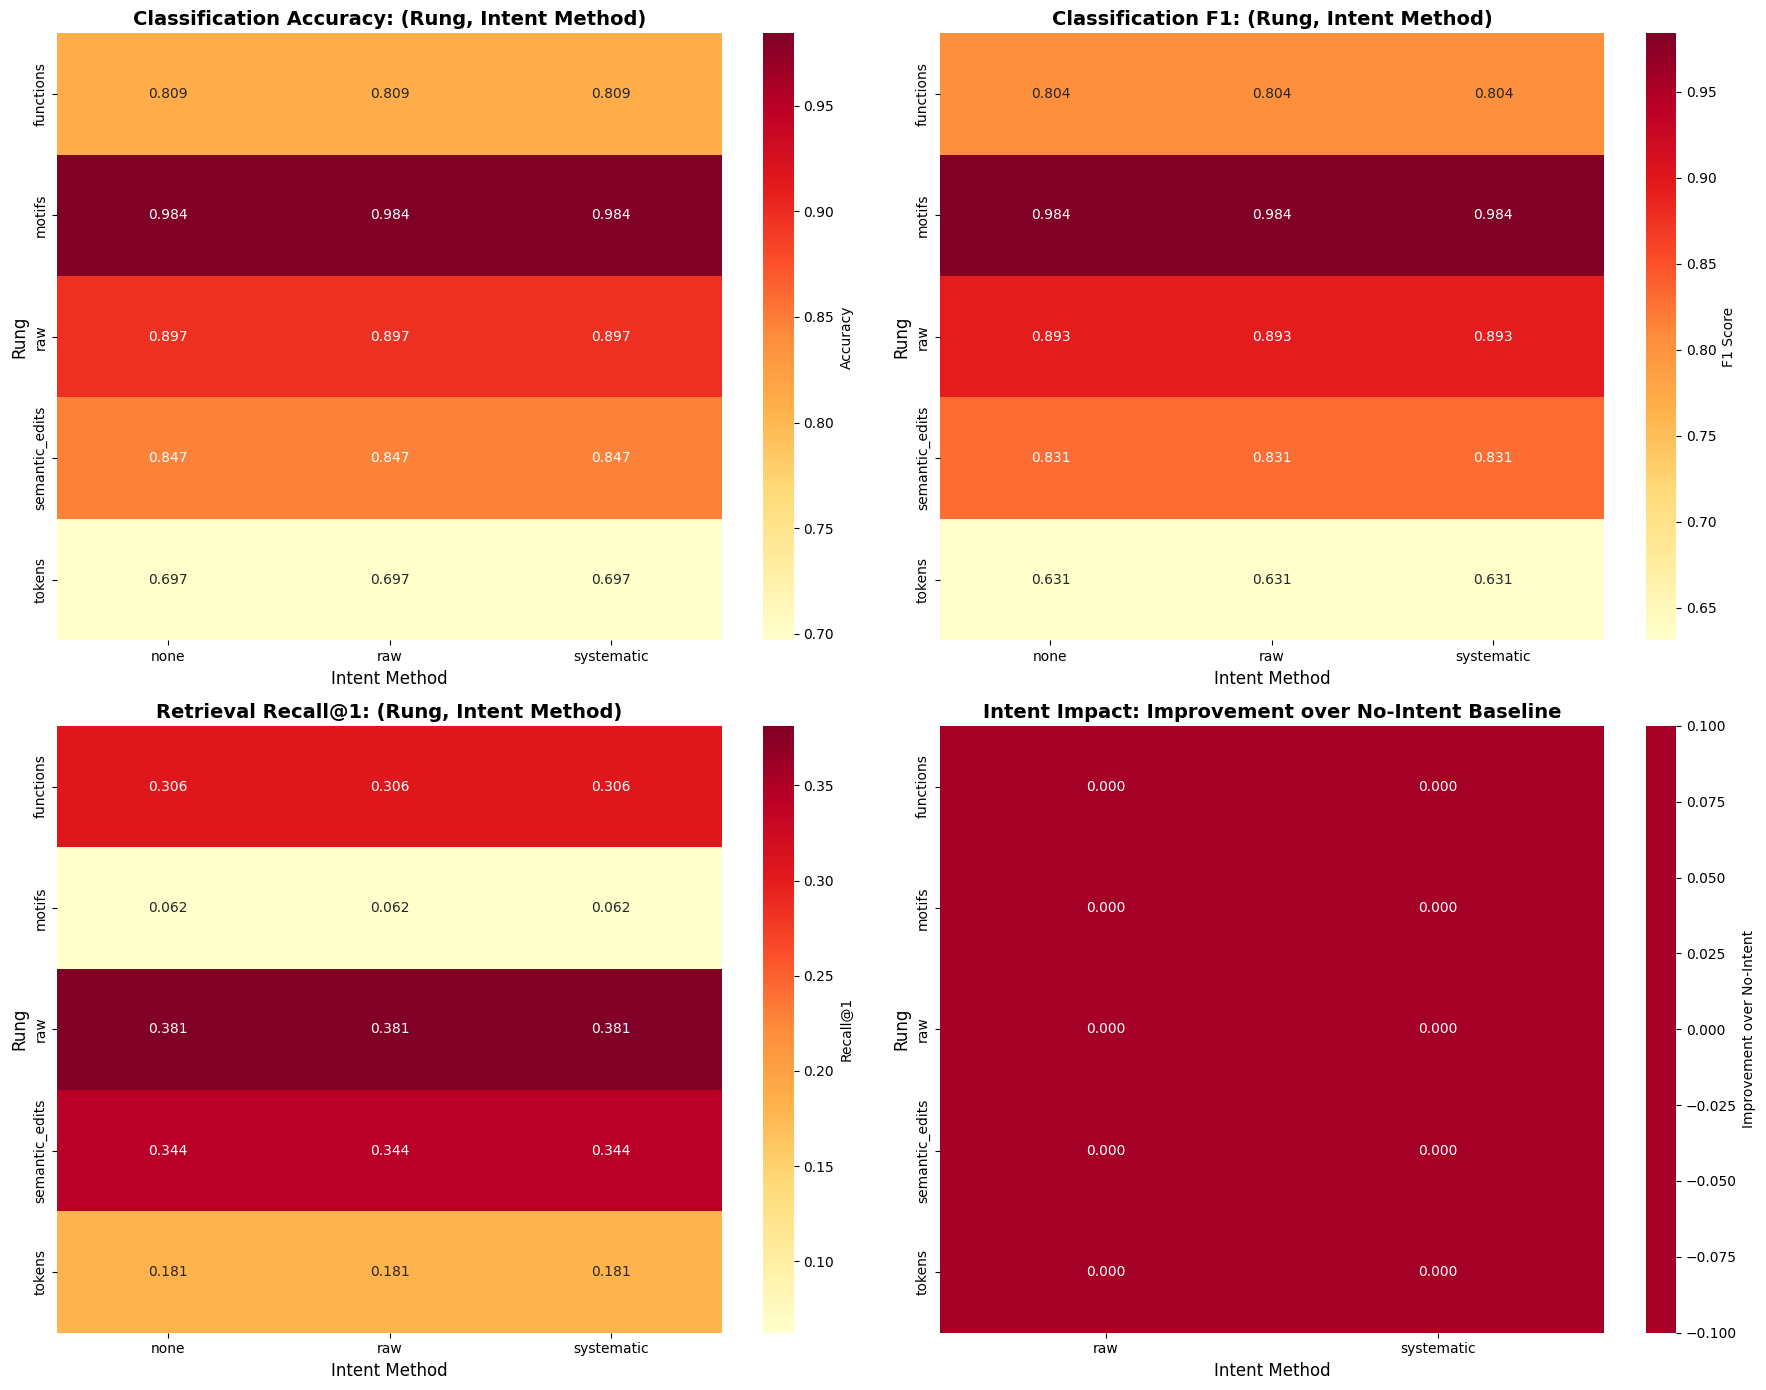

INTER-PROBE DIFFERENCE: WITH vs WITHOUT INTENT

Comparison: Inter-Probe Difference With vs Without Intent:
                        task   metric  no_intent_difference  avg_with_intent_difference  max_with_intent_difference  intent_impact
code_activity_classification accuracy              0.293750                    0.293750                    0.293750            0.0
code_activity_classification       f1              0.353383                    0.353383                    0.353383            0.0
   multi_file_classification accuracy              0.281250                    0.281250                    0.281250            0.0
   multi_file_classification       f1              0.352357                    0.352357                    0.352357            0.0
           anomaly_detection accuracy              0.000000                    0.000000                    0.000000            0.0
           anomaly_detection       f1              0.000000                    0.000000                    

✓ Saved visualization to /Users/hamidaho/new_cursor/research/results/inter_probe_difference_analysis.png


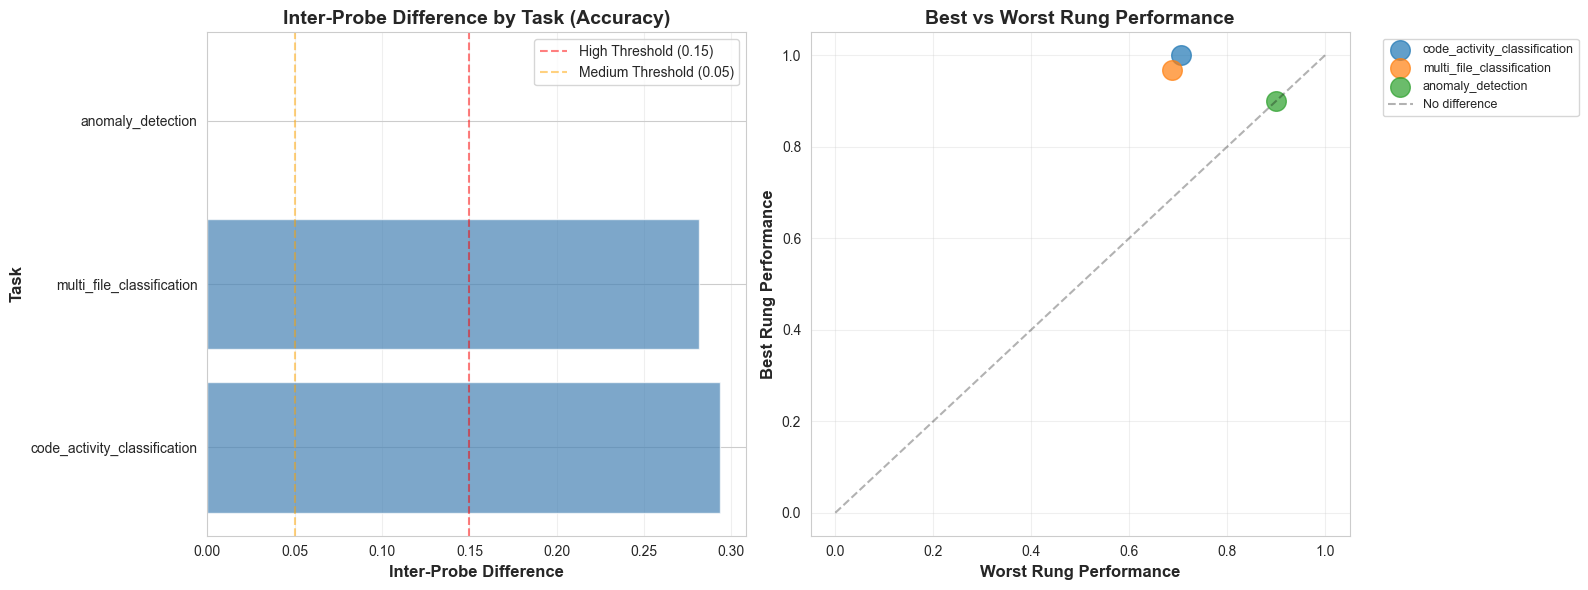

## Research Implications

### Key Findings

1. **Task-Specific Rung Selection is Critical**
   - Classification tasks → Motifs excel (100% accuracy, most efficient)
   - Retrieval tasks → Semantic edits or functions (motifs too abstract)
   - Tokens perform poorly across all tasks

2. **Privacy-Utility Trade-off is Task-Dependent**
   - Motifs: High privacy, excellent classification, poor retrieval
   - Semantic edits: Lower privacy, good retrieval, good classification  
   - Functions: Balanced privacy-utility for both tasks

3. **Storage Efficiency Scales Dramatically**
   - Motifs are 4-13x more efficient while achieving better classification
   - Critical for large-scale deployment and foundation model training

4. **Abstraction Can Improve Performance**
   - Higher abstraction (motifs) captures structural patterns that generalize better
   - Suggests structural patterns matter more than raw content for classification

### Next Research Directions

1. **Why Motifs Excel at Classification**
   - Analyze which motifs are most predictive
   - Understand structural pattern generalization

2. **Why Tokens Perform Poorly**
   - Investigate if structured token representations improve performance
   - Compare with canonicalized vs raw tokens

3. **Cross-Task Generalization**
   - Test patterns across different classification tasks
   - Identify retrieval tasks where motifs might work better

4. **Privacy Quantification**
   - Measure actual k-anonymity values
   - Quantify re-identification risk

5. **Foundation Model Training**
   - Test if motifs can train better code models
   - Validate storage efficiency enables larger datasets
